In [32]:
##!pip install beautifulsoup4
##!pip install -U selenium
##!pip install webdriver_manager --user
## I used the above code to install the necessary libraries for web scraping...

### Below are the needed libraries/sublibraries:
from datetime import date
from datetime import datetime
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
import requests
from webdriver_manager.chrome import ChromeDriverManager

driver = webdriver.Chrome(ChromeDriverManager().install())
content = driver.page_source
soup = BeautifulSoup(content)



====== WebDriver manager ======
Current google-chrome version is 91.0.4472
Get LATEST driver version for 91.0.4472
Driver [/Users/floyd/.wdm/drivers/chromedriver/mac64/91.0.4472.101/chromedriver] found in cache


In [33]:
## driver.get(url) retrieves that url from the specified driver object
url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'

## fetch raw html data
html_content = requests.get(url).text
soup = BeautifulSoup(html_content, "lxml")
print(soup.title.text) # print the parsed data of html title only


	
	 Daily Treasury Yield Curve Rates 
    




In [34]:
## Set an object for the table in question on the website

treasury_table = soup.find("table", attrs={"class": "t-chart"})

## Then set an object where it finds all the table heading values and rates 

t_table_data = treasury_table.find_all("tr")

## Set an empty array to be populated with the heading values of the table

headings = []
rates = []

## For loop that starts at index 0 of the row and finds all the "th" tags in the treasury_table object
## The "th" tag is just specific to this example, and there are numerous different tags to look out for.
## The result of the for loop is to get rid of any new lines and extra spaces by using the .replace() method 
## with the .strip() method which acts to strip spaces and new lines created by any \n commands

for th in t_table_data[0].find_all("th"):
    # remove any newlines and extra spaces from left and right
    headings.append(th.text.replace('\n', ' ').strip())

## Specify [1] index to get the next row. 
## if I had a bunch of rows i could just make a for loop that iterates from 1->x such as
##
##  "for i in t_table_data: 
##        for td in t_table_data[i].find_all("td"): etc."
##
## Now I can turn these into a dataframe.

for td in t_table_data[1].find_all("td"):
    rates.append(td.text.replace('\n'," ").strip())



print(headings)
print(rates)

['Date', '1 mo', '2 mo', '3 mo', '6 mo', '1 yr', '2 yr', '3 yr', '5 yr', '7 yr', '10 yr', '20 yr', '30 yr']
['07/01/21', '0.05', '0.05', '0.05', '0.05', '0.09', '0.25', '0.47', '0.89', '1.24', '1.48', '2.01', '2.07']


In [35]:
## If you enter the data in as a list it will put it all into one column, which we don't want.
## You can use .T to transpose the data to how we need it.

yields = pd.DataFrame(data=rates).T
yields.columns = headings
yields

,Date,1 mo,2 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,7 yr,10 yr,20 yr,30 yr
0,07/01/21,0.05,0.05,0.05,0.05,0.09,0.25,0.47,0.89,1.24,1.48,2.01,2.07


In [36]:
## saving the data to a csv for later use...

yields.to_csv(r'/Users/floyd/Projects1/yieldcurve.csv', header=True)


In [848]:
## Now we have a data frame that has the yields from the most recent day. Next we will see if we can just make this
## data frame update. We will likely have to save this to a csv and make a function out of our code.

In [37]:
import numpy as np

In [61]:
def TreasuryScraper():
    ## driver.get(url) retrieves that url from the specified driver object
    global yields
    today = date.today()
    today = today.strftime("%m/%d/%y")
    today_obj = datetime.now()
    url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'
    ## fetch raw html data
    html_content = requests.get(url).text
    soup = BeautifulSoup(html_content, "lxml")
    treasury_table = soup.find("table", attrs={"class": "t-chart"})
    t_table_data = treasury_table.find_all("tr")
    headings1 = []
    rates1 = []
    if today_obj.weekday() >=5 :
        outside = print("\nIt's a weekend, go outside!\n")
        return yields.head(), outside
    elif yields["Date"].iloc[-1] == today:
        print("\nNo updates until tomorrow! Here are the most recent yields: \n")
        return yields
    else:
        for th in t_table_data[0].find_all("th"):
                # remove any newlines and extra spaces from left and right
            headings1.append(th.text.replace('\n', ' ').strip())
        for i in np.arange(1 + len(yields.index), 2 + len(yields.index)):  ### this starts at the most recent date
            for td in t_table_data[i].find_all("td"):
                rates1.append(td.text.replace('\n'," ").strip())
        yields2 = pd.DataFrame(data=rates1).T
        yields2.columns = headings
        yields = pd.concat([yields, yields2], axis=0, ignore_index=True)
        yields.to_csv(r'/Users/floyd/Projects1/yieldcurve.csv', header=True)
        return yields
    


In [62]:
## now we will just get new treasury rates and it will break if we are up to date!
TreasuryScraper()


It's a weekend, go outside!



(       Date  1 mo  2 mo  3 mo  6 mo  1 yr  2 yr  3 yr  5 yr  7 yr 10 yr 20 yr  \
 0  07/01/21  0.05  0.05  0.05  0.05  0.09  0.25  0.47  0.89  1.24  1.48  2.01   
 1  07/02/21  0.05  0.05  0.05  0.05  0.08  0.24  0.45  0.86  1.19  1.44  1.98   
 
   30 yr  
 0  2.07  
 1  2.05  ,
 None)

In [63]:
import matplotlib.pyplot as plt
import numpy as np
def YieldCurvePlot():
    yield_curve = pd.read_csv('/Users/floyd/Projects1/yieldcurve.csv')
    yield_curve = yield_curve.T.iloc[1:,-1]
    yield_curve = pd.DataFrame(data=yield_curve)
    x_length = np.array(np.arange(0,2.4, step=0.2))
    fig, ax = plt.subplots()
    ax.scatter(x_length, yield_curve.iloc[1:,-1].astype(np.float), color='midnightblue',
              marker='v', linestyle="-",s=20,linewidth=2, alpha=1)
    ticks=[]
    for i in yield_curve.index[1:]:
        ticks.append(i)
    plt.xticks(ticks=np.arange(0,2.4,0.2), labels=ticks, fontsize=8)
    title = yield_curve.iloc[0,-1]
    ax.set_title(f"{title} Treasury Yields", fontsize=14, color='black')
    ax.text(1.1,0.1,"Source: Department of Treasury", color='midnightblue')
    ax.set_xlabel("Maturity Schedule", color='midnightblue',fontsize=12)
    ax.set_ylabel("Yield (%)", color="midnightblue", fontsize=12)
    ax.set_facecolor('azure')
    fig.set_facecolor('gainsboro')
    plt.savefig('/Users/floyd/Projects1/yieldcurvetoday.png')
    plt.show()


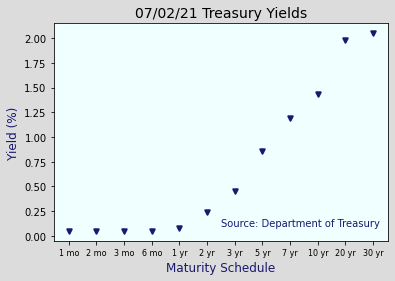

In [64]:
## this function just plots the most recent treasury yields. Idk why the line didn't show up.

YieldCurvePlot()